In [ ]:
import tensorflow as tf

import os
import time

import matplotlib.pyplot as plt
from IPython import display

In [ ]:
pip install -q -U tensorboard

In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 2s 0us/step


In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w//2

  real_image = image[:,:w,:]
  input_image = image[:,w:,:]

  input_image = tf.cast(input_image,tf.float32)
  real_image = tf.cast(real_image,tf.float32)

  return input_image,real_image

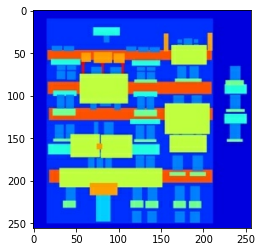

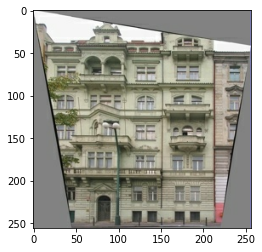

In [ ]:
inp,re = load(PATH+'train/100.jpg')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
def resize(input_image,real_image,height,width):
  input_image = tf.image.resize(input_image,(height,width),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image  = tf.image.resize(real_image,(height,width),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image,real_image

In [ ]:
def random_crop(input_image,real_image):
  stacked_images = tf.stack([input_image,real_image],axis=0)
  cropped_images = tf.image.random_crop(stacked_images,[2,IMG_HEIGHT,IMG_WIDTH,3])
  return cropped_images[0],cropped_images[1]

In [ ]:
#Normalizing the image to -1 and 1
def normalize(input_image,real_image):
  input_image = (input_image/127.5)-1
  real_image = (real_image/127.5)-1

  return input_image,real_image

In [ ]:
@tf.function
def random_jittering(input_image,real_image):
  input_image,real_image = resize(input_image,real_image,286,286)

  input_image,real_image = random_crop(input_image,real_image)

  if tf.random.uniform(()) > 0.5:
    #Random Mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image  = tf.image.flip_left_right(real_image)

  return input_image,real_image

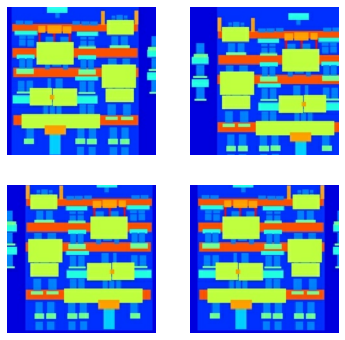

In [ ]:
fig = plt.figure(figsize=(6,6))
for i in range(4):
  ax = fig.add_subplot(2,2,i+1)
  rj_inp,rj_re = random_jittering(inp, re)
  ax.imshow(rj_inp/255.0)
  ax.axis('off')

In [ ]:
def load_image_train(image_file):
  input_image,real_image = load(image_file)
  input_image,real_image = random_jittering(input_image,real_image)
  input_image,real_image = normalize(input_image,real_image)

  return input_image,real_image

In [ ]:
def load_image_test(image_file):
  input_image,real_image = load(image_file)
  input_image,real_image = resize(input_image,real_image,IMG_HEIGHT,IMG_WIDTH)
  input_image,real_image = normalize(input_image,real_image)

  return input_image,real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
a,b = next(iter(train_dataset))
print(a.shape)

(1, 256, 256, 3)


In [ ]:
def downsample(filters,size,apply_batch_norm=True):
  initializer = tf.random_normal_initializer(0.,0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',
                                    kernel_initializer=initializer,use_bias=False))
  if apply_batch_norm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
def upsample(filters,size,apply_dropout=False):
  initializer = tf.random_normal_initializer(0.,0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,
                                             padding='same',kernel_initializer=initializer,
                                             use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.ReLU())

  return result


In [ ]:
def Generator():
      inputs = tf.keras.layers.Input(shape=[256,256,3])
      down_stack = [
                    downsample(64,4,apply_batch_norm=False), # (128,128,64)
                    downsample(128,4),    #(64,64,128)
                    downsample(256,4),    #(32,32,256)
                    downsample(512,4),    #(16,16,512)
                    downsample(512,4),    #(8,8,512)
                    downsample(512,4),    #(4,4,512)
                    downsample(512,4),    #(2,2,512)
                    downsample(512,4)    #(1,1,512)
      ]

      up_stack = [
                  upsample(512,4,apply_dropout=True), #(2,2,1024)
                  upsample(512,4,apply_dropout=True), #(4,4,1024)
                  upsample(512,4,apply_dropout=True), #(8,8,1024)
                  upsample(512,4),    #(16,16,1024)
                  upsample(256,4),    #(32,32,512)
                  upsample(128,4),    #(64,64,256)
                  upsample(64,4),    #(128,28,128)
      ]

      initializer = tf.random_normal_initializer(0.,0.02)
      last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,strides=2,padding='same',
                                             kernel_initializer=initializer,
                                             activation = 'tanh')
      x = inputs
      # Downsampling
      skips = []
      for down in down_stack:
        x = down(x)
        skips.append(x)
      
      skips = reversed(skips[:-1])

      # Upsampling and Skip Connections

      for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
      
      x = last(x)
      return tf.keras.Model(inputs=inputs,outputs=x)

In [ ]:
generator = Generator()

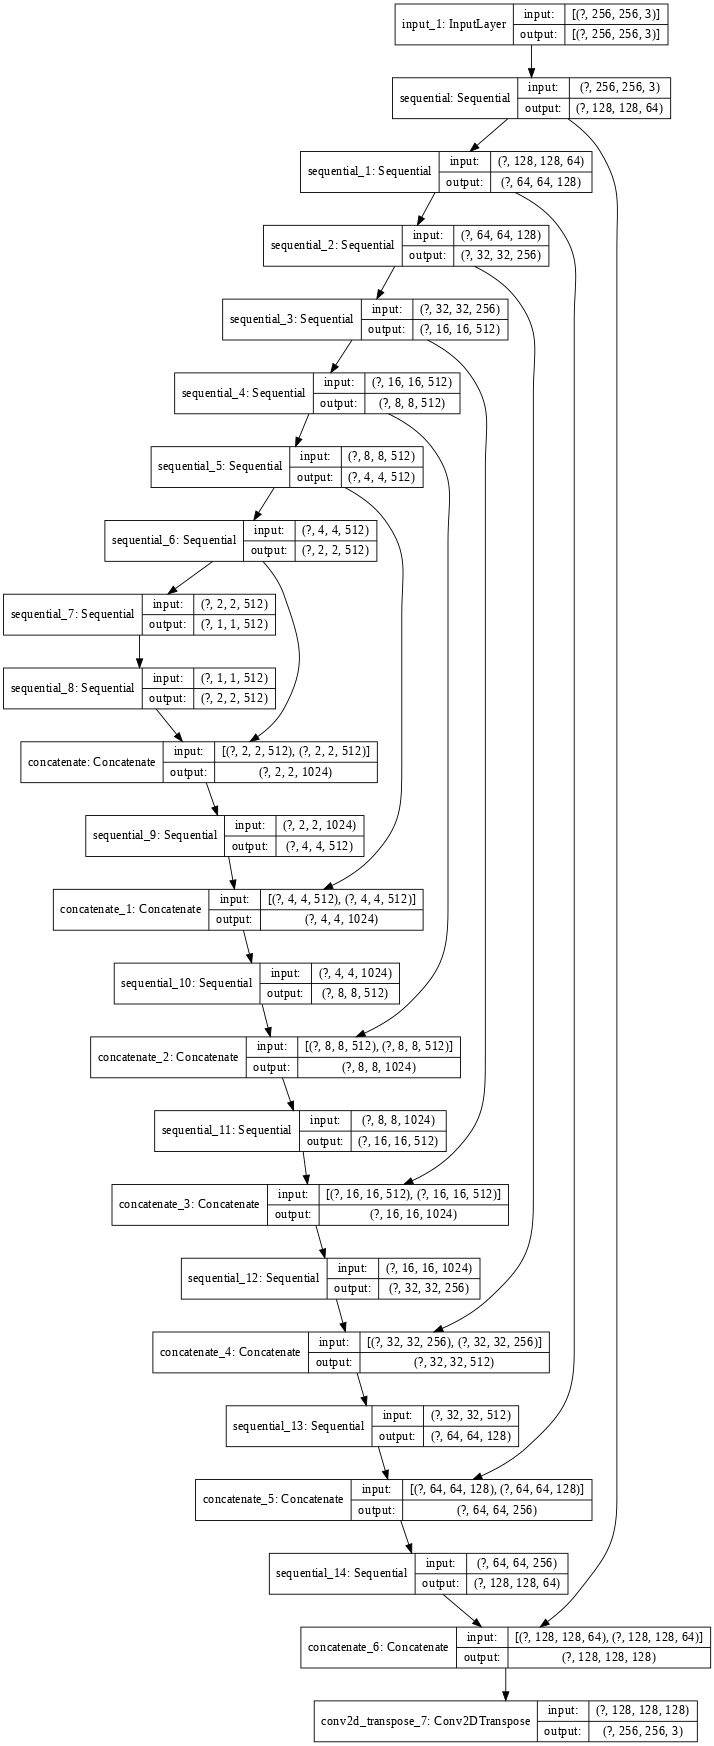

In [ ]:
tf.keras.utils.plot_model(generator,show_shapes=True,dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


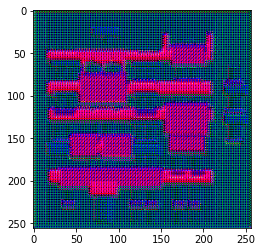

In [ ]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...])

In [ ]:
#This calue of lambda was used in the original paper
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output,gen_output,target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)

  #Mean Absolute Error
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
  total_gen_loss = gan_loss+(LAMBDA*l1_loss)

  return total_gen_loss,gan_loss,l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_uniform_initializer(0.,0.02)
  inp = tf.keras.layers.Input(shape=[256,256,3],name = 'input_image')
  tar = tf.keras.layers.Input(shape=[256,256,3],name = 'target_image')

  x = tf.keras.layers.concatenate([inp,tar])  #(256,256,channels*2)

  down1 = downsample(64,4,False)(x)  # (128,128,64)
  down2 = downsample(128,4)(down1)       # (64,64,128)
  down3 = downsample(256,4)(down2)       # (32,32,256)
  
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  #(34,34,256)
  conv = tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  #(31,31,512)

  batch_norm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm1)
  zero_pad2  = tf.keras.layers.ZeroPadding2D()(leaky_relu) #(33,33,512)

  last = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    #(30,30,1)

  return tf.keras.Model(inputs=[inp,tar],outputs=last)



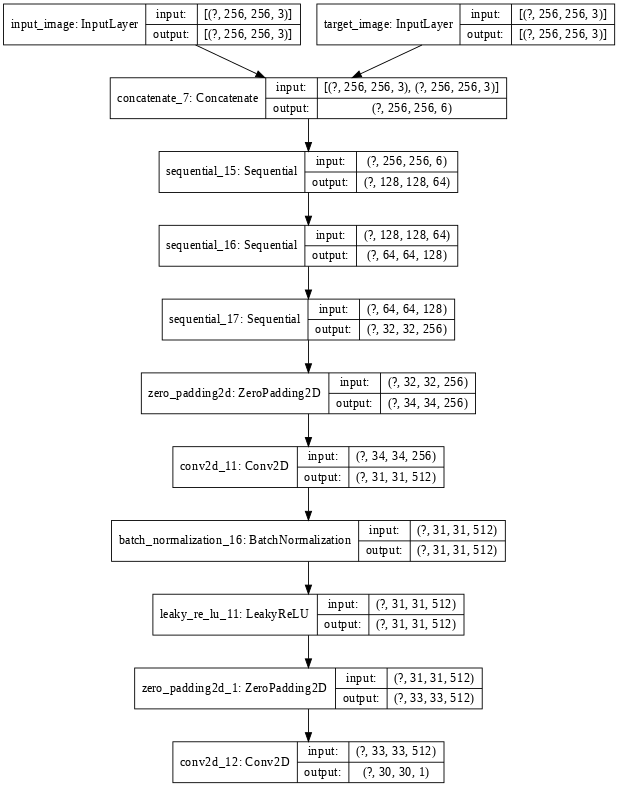

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator,show_shapes=True,dpi=64)

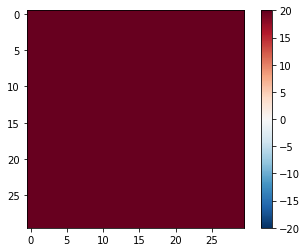

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output,disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)

  total_disc_loss = real_loss+generated_loss
  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [ ]:
checkpoint_dir = "./ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### From the Paper :
 **This differs
from the usual protocol in that we apply dropout at test time,
and we apply batch normalization using the statistics of
the test batch, rather than aggregated statistics of the train-
ing batch. This approach to batch normalization, when the
batch size is set to 1, has been termed “instance normal-
ization” and has been demonstrated to be effective at im-
age generation tasks**

In [ ]:
def generate_image(model,test_inp,target):
  prediction = model(test_inp,training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_inp[0],target[0],prediction[0]]
  title = ['Input Image','Ground Truth','Predicted Image']
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i])
    plt.imshow(display_list[i]*0.5+0.5)
    plt.axis('off')
  plt.show()


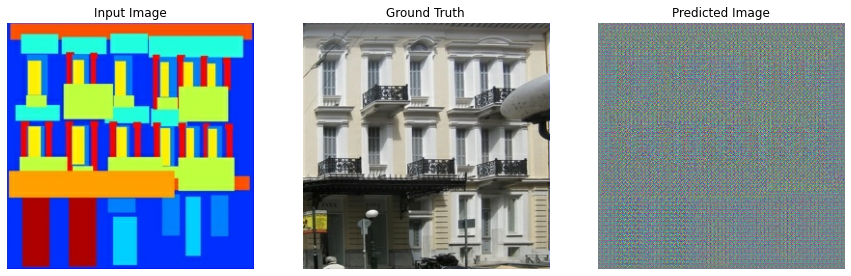

In [ ]:
for example_input,example_target in test_dataset.take(1):
  generate_image(generator,example_input,example_target)

In [ ]:
EPOCHS=150

In [ ]:
import datetime
log_dir = 'logs/'
summary_writer = tf.summary.create_file_writer(log_dir+'fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
def train_step(input_image,target,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training=True)

        disc_real_output = discriminator([input_image,target],training=True)
        disc_generator_output = discriminator([input_image,gen_output],training=True)

        gen_total_loss,gen_gan_loss,gen_l1_loss = generator_loss(disc_generator_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generator_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds,epochs,test_ds):
  for epoch in range(epochs):
    start = time.time()
    display.clear_output(wait=True)
    for example_input,example_target in test_ds.take(1):
      generate_image(generator,example_input,example_target)
    print("Epoch: ",epoch)

    #Training
    for n,(input_image,target) in train_ds.enumerate():
      print('.',end='')
      if(n+1)%100==0:
        print()
      train_step(input_image,target,epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_dir)
    print ('Time taken for epoch {} is {:.3f} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)